#1. Initial Setting

In [ ]:
import numpy as np
Nsub = 50
TimePeriod = 100
SamplePath = 50 * Nsub
lower_bound = 1e-4
theta2 = np.array([0.94,0.9919,0.0827])

# theta1 = np.array([3, -1, -2, 0,9, 2.5,
#                    4, -2, -1,1, 9.5, 3])

theta1 = np.array([1.9, -2.2, -0.4, 1, 10.7,  12.5,
                   1.2,-0.5, -0.2, 0, 5.2, 7.7])
#theta1 = theta1/np.max(np.abs(theta1))#np.linalg.norm(theta1)
print(theta1)

dim_sh = 2
dim_z = 2
dim_so = 4*4
dim_a = 3
dim_discrete = 100

old_sh = np.arange(dim_sh,dtype = int)
old_z = np.arange(dim_z,dtype = int)
old_so = np.arange(dim_so,dtype = int) #old_n1*3+old_n2
old_n1 = old_so//4
old_n2 = old_so%4
old_a1 = np.arange(dim_a,dtype = int)
old_a2 = np.arange(dim_a,dtype = int)
old_x = np.linspace(0,1,num=dim_discrete)

[ 1.9 -2.2 -0.4  1.  10.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7]


#2. POSG Initial Function

##2.1 Dynamic

In [ ]:
######P(ni'|ni,ai)-->action*(ni+nj)*(ni+nj)-->3*9*9######
dy_a1so = np.zeros([dim_a,4,4])
dy_a2so = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_a1so[ai,ni_old,ni_new] = 1
        dy_a2so[ai,ni_old,ni_new] = 1
dy_a1so[0,0,0] = 1
dy_a2so[0,0,0] = 1
dy_a1so[2,3,3] = 1
dy_a2so[2,3,3] = 1
#print(dy_a1so,dy_a2so)
dy_a1so = (dy_a1so[:,old_n1,:])[:,:,old_n1]
dy_a2so = (dy_a2so[:,old_n2,:])[:,:,old_n2]
# print(dy_a1so,'\n',dy_a2so)
# print(dy_a1so.shape,dy_a2so.shape)

######P(z',sh'|sh)-->sh_old*(sh_new)*(z_new)-->2*2*2######

def DynamicPartial(theta2):
  trans = np.zeros([dim_sh,dim_sh]) #sh_old*sh_new: 2*2
  obser = np.zeros([dim_sh,dim_z])  #sh_new*z_new: 2*2
  dy_trob = np.zeros([dim_sh,dim_sh,dim_z])#sh_old*sh_new*z_new: 2*2*2

  trans_val = theta2[0:2]
  obser_val = theta2[-1]

  trans[0,0],trans[1,1] = trans_val[0],trans_val[1]
  trans[0,1],trans[1,0] = 1-trans[0,0],1-trans[1,1]
  obser[0,0] = obser[1,1] = 1-obser_val
  obser[0,1] = obser[1,0] = obser_val

  dy_trob = np.stack([trans,trans],axis=2)*np.stack([obser,obser],axis=0)
  return trans,obser,dy_trob
trans,obser,dy_trob = DynamicPartial(theta2)
# print(trans,obser)
# for sh_old in range(dim_sh):
#   for sh_new in range(dim_sh):
#     for z_new in range(dim_z):
#       print(dy_trob[sh_old,sh_new,z_new],trans[sh_old,sh_new]*obser[sh_new,z_new])

##2.2 Reward

In [ ]:
import itertools
######r(x,so,ai)-->belief*(ni+nj)*actioni-->50*9*3######
def RewardPartial(theta1,num=dim_discrete):
  rd1_sh = np.zeros([dim_sh,dim_so,dim_a])
  rd2_sh = np.zeros([dim_sh,dim_so,dim_a])

  rd1_bf = np.zeros([num,dim_so,dim_a])
  rd2_bf = np.zeros([num,dim_so,dim_a])  
  for sh,ai in itertools.product(range(dim_sh),range(dim_a)):
    rd1_sh[sh,:,ai] = old_n1*(theta1[0] + old_n1*theta1[1] + old_n2*theta1[2] +(sh==0) *theta1[3] + (sh==1)*theta1[4]) -(ai==2) *theta1[5]
    rd2_sh[sh,:,ai] = old_n2*(theta1[6] + old_n2*theta1[7] + old_n1*theta1[8] +(sh==0) *theta1[9]+ (sh==1)*theta1[10]) -(ai==2) *theta1[11]
  
  xold = np.linspace(0,1,num=num)
  for so,ai in itertools.product(range(dim_so),range(dim_a)):
    rd1_bf[:,so,ai] = xold * rd1_sh[0,so,ai] + (1-xold) * rd1_sh[1,so,ai]
    rd2_bf[:,so,ai] = xold * rd2_sh[0,so,ai] + (1-xold) * rd2_sh[1,so,ai]
  # xold = np.stack([xold for i in range(dim_so)],axis=1)
  # xold = np.stack([xold for i in range(dim_a)],axis=2)
  return rd1_bf,rd2_bf,[rd1_sh,rd2_sh]
#print(RewardPartial(theta1))

##2.3 SigmaLambda

In [ ]:
def SigmaLambda(theta2,xold = old_x,znew=old_z,num=dim_discrete,T=None):
  _,_,dytrob = DynamicPartial(theta2)
  if T==None: #generate function for Q value iteration
    xold = np.linspace(0,1,num=num)
    znew = np.arange(dim_z,dtype= int)
    sigma = np.zeros([num,dim_z]) # x_old,z_new
    xnew = np.zeros([num,dim_z])  # x_old,z_new

    for z_new in znew:
      xnew_temp = dytrob[0,0,z_new]*xold + dytrob[1,0,z_new]*(1-xold)
      sigma[:,z_new] = xnew_temp + dytrob[0,1,z_new]*xold + dytrob[1,1,z_new]*(1-xold)
      xnew[:,z_new] = xnew_temp/sigma[:,z_new]

  elif T==1: #generate data set
    #sigma = np.zeros(len(xold))
    #xnew = np.zeros(len(xold))
    xnew_temp = dytrob[0,0,znew]*xold + dytrob[1,0,znew]*(1-xold)
    sigma = xnew_temp + dytrob[0,1,znew]*xold + dytrob[1,1,znew]*(1-xold)
    xnew = xnew_temp/sigma

  else: # recover process
    sigma = np.zeros([T,len(xold)]) #T,N
    xnew = np.zeros([T+1,len(xold)]) #T+1, N
    xnew[0] = xold
    for t in range(T):
      z_new = znew[t+1]
      x_old = xnew[t]
      xnew_temp = dytrob[0,0,z_new]*x_old + dytrob[1,0,z_new]*(1-x_old)
      sigma[t] = xnew_temp + dytrob[0,1,z_new]*x_old + dytrob[1,1,z_new]*(1-x_old)
      xnew[t+1] = xnew_temp/sigma[t]
  
  belief_f = np.floor(xnew*(num-1))/(num-1)
  belief_c = np.ceil(xnew*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (xnew-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]   

  return sigma,xnew,[iterpolate, np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))]   

#SigmaLambda(theta2) 

##2.4 ValueIteration

In [ ]:
from scipy.special import logsumexp
from scipy.special import softmax

def ValuePartial(theta1,theta2 = theta2,num=dim_discrete,beta=0.9,gamma=0.5772,inner=1e-3,outer=1e-3):
  rd1_bf,rd2_bf,_ = RewardPartial(theta1,num=num)
  sigma,xnew,[it,bf,bc] = SigmaLambda(theta2,num=num) #xold,znew
  
  it = np.stack([np.stack([it for so_new in range(dim_so)],axis=2) for a_new in range(dim_a)],axis=3)
  si = np.stack([sigma for so_new in range(dim_so)],axis=2)

  Q1_new = np.zeros([num,dim_so,dim_a]) # 50*9*3
  Q2_new = np.zeros([num,dim_so,dim_a])
  
  pi1_new = np.ones([num,dim_so,dim_a])/dim_a
  #pi2_new = np.ones([num,dim_so,dim_a])/dim_a
  pi2_old = pi1_new.copy()

  for ol in range(1000):
    pi1_old = pi1_new.copy()
    for il in range(1000):
      Q2_old = Q2_new.copy()

      #Vbar2 #xnew, so_new--> xold,znew,so_new
      Vbar2 = gamma + logsumexp(it*Q2_old[bf,:,:] + (1-it)*Q2_old[bc,:,:],axis=3) #xold,znew,so_new ,(ai)
      Vbar2 = np.sum(si * Vbar2,axis=1) #xold, (znew),so_new

      for a2,so_old in itertools.product(range(dim_a),range(dim_so)):
        Q2_temp = np.zeros([dim_a,dim_so,num]) #a1,so_new,xold
        for a1,so_new in itertools.product(range(dim_a),range(dim_so)):
          Q2_temp[a1,so_new] = Vbar2[:,so_new]*dy_a1so[a1,so_old,so_new]*dy_a2so[a2,so_old,so_new]*pi1_old[:,so_old,a1]
        Q2_new[:,so_old,a2] = rd2_bf[:,so_old,a2] + beta*(np.sum(np.sum(Q2_temp,axis=1),axis=0))
      if ol==0 and il==0:
        error_in2 = 1
      else:
        error_in2 = np.max(np.abs((Q2_new-Q2_old)/Q2_old))
      #print('Q2',il,error_in2,np.max(np.abs(Q2_old)))
      if error_in2 <inner:
        #print('Q2',il,error_in2,np.max(np.abs(Q2_old)))
        break
    pi2_new = softmax(Q2_new,axis=2)
    error_ot2 = np.max(np.abs((pi2_old-pi2_new)/pi2_old))

    pi2_old = pi2_new.copy()
    for il in range(1000):
      Q1_old = Q1_new.copy()

      #Vbar2 #xnew, so_new--> xold,znew,so_new
      Vbar1 = gamma + logsumexp(it*Q1_old[bf,:,:] + (1-it)*Q1_old[bc,:,:],axis=3) #xold,znew,so_new ,(ai)
      Vbar1 = np.sum(si * Vbar1,axis=1) #xold, (znew),so_new

      for a1,so_old in itertools.product(range(dim_a),range(dim_so)):
        Q1_temp = np.zeros([dim_a,dim_so,num]) #a1,so_new,xold
        for a2,so_new in itertools.product(range(dim_a),range(dim_so)):
          Q1_temp[a2,so_new] = Vbar1[:,so_new]*dy_a1so[a1,so_old,so_new]*dy_a2so[a2,so_old,so_new]*pi2_old[:,so_old,a2]
        Q1_new[:,so_old,a1] = rd1_bf[:,so_old,a1] + beta*(np.sum(np.sum(Q1_temp,axis=1),axis=0))
      if ol==0 and il==0:
        error_in1 = 1
      else:
        error_in1 = np.max(np.abs((Q1_new-Q1_old)/Q1_old))
      #print('Q1',il,error_in1,np.max(np.abs(Q1_old)))
      if error_in1 <inner:
        #print('Q1',il,error_in1,np.max(np.abs(Q1_old)))
        break
    pi1_new = softmax(Q1_new,axis=2)
    error_ot1 = np.max(np.abs((pi1_old-pi1_new)/pi1_old))

    #print(ol,error_ot1,error_ot2)
    if error_ot1 < outer and error_ot2 < outer:
      break
  return Q1_new,Q2_new,pi1_new,pi2_new

import time
start = time.time()
Q1,Q2,pi1,pi2 = ValuePartial(theta1)
print(time.time()-start)

4.2979230880737305


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


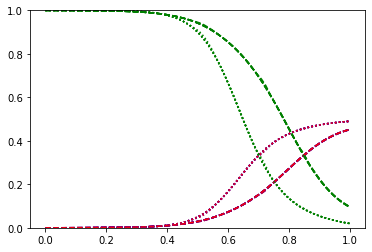

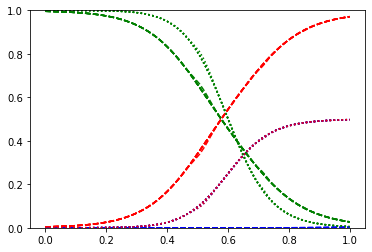

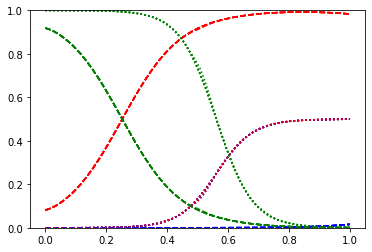

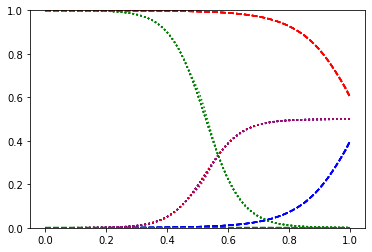

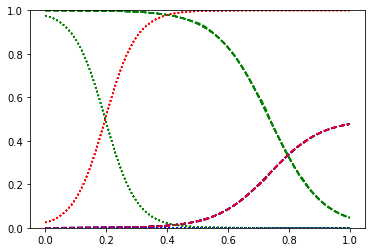

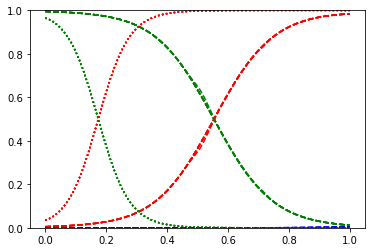

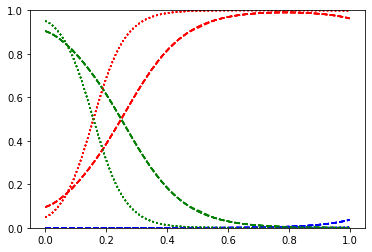

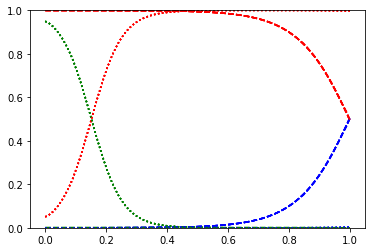

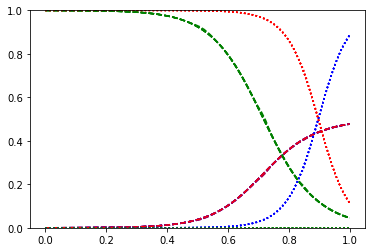

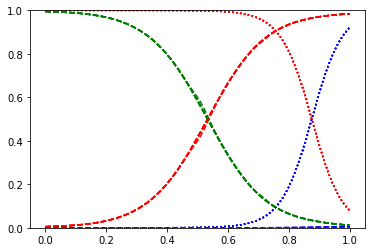

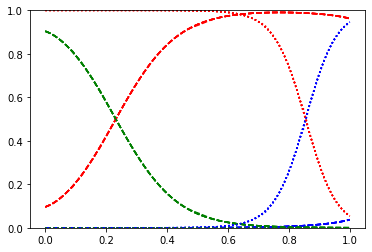

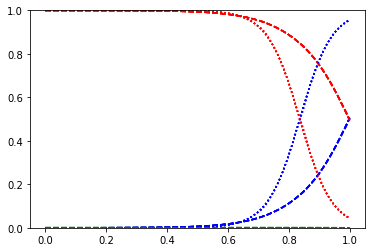

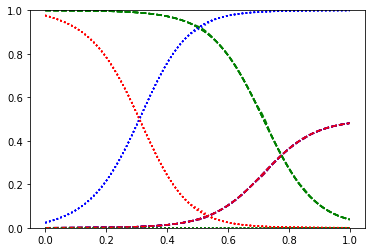

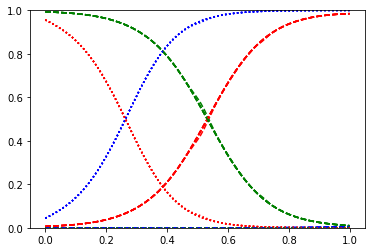

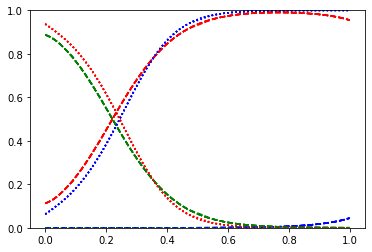

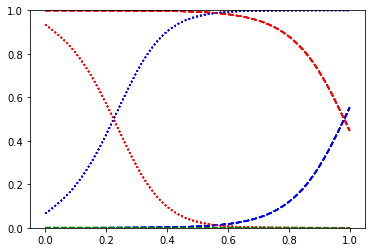

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
discrete_tol = 10*(1+np.array([5,6,7,8,9,10]))
Q1_plot = []
Q2_plot = []
pi1_plot = []
pi2_plot = []
for num_disc in tqdm(discrete_tol):
  x_old_test = np.linspace(0,1,num_disc)
  Q1,Q2,pi1,pi2 = ValuePartial(theta1,num=num_disc)
  Q1_plot.append(Q1)
  Q2_plot.append(Q2)
  pi1_plot.append(pi1)
  pi2_plot.append(pi2)

for so in range(dim_so):
  for i in range(len(discrete_tol)):
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,0],'b--')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,1],'r--')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,2],'g--')
  
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,0],'b:')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,1],'r:')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,2],'g:')
  plt.ylim(0,1)
  plt.show()

# 3. Data Generation

In [ ]:
from tqdm import tqdm
def DataGeneration(theta1 = theta1,theta2=theta2,T=TimePeriod,N=SamplePath,Nsub = Nsub,num=dim_discrete):
  trans,obser,dy_trob = DynamicPartial(theta2)
  _,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)

  hstate = np.zeros([T+1,N],dtype= int)    #hidden state (s^h)
  ostate = np.zeros([T+1,N],dtype = int)  #observalbe state s^o =(n1,n2) -> n1*3+n2
  zstate = np.zeros([T+1,N],dtype = int)   #observation state z
  belief = np.zeros([T+1,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  sigma = np.zeros([T,N])

  belief[0,:] = np.kron(np.ones(int(N/Nsub)),np.linspace(0,1,int(Nsub)))#np.random.uniform(size=N)
  hstate[0,:] = np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  ostate[0,:] = 0#np.random.randint(0,dim_so,size=N)

  # action1[0,:] = np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  # action2[0,:] = np.ones(N,dtype = int)   #agent2's action open store (initial n2=0)    


  for t in tqdm(range(T)):
    # iterpolate belief
    belief_f = np.floor(belief[t,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    os = ostate[t,:]

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[belief_fint,os,0] + (1-iterpolate)*pi1[belief_cint,os,0]
    p12 = iterpolate*pi1[belief_fint,os,1] + (1-iterpolate)*pi1[belief_cint,os,1]
    action1[t,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[belief_fint,os,0] + (1-iterpolate)*pi2[belief_cint,os,0]
    p22 = iterpolate*pi2[belief_fint,os,1] + (1-iterpolate)*pi2[belief_cint,os,1]
    action2[t,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income

    ostate[t+1,:] = np.int_(np.where(dy_a1so[action1[t],os,:] * dy_a2so[action2[t],os,:]==1)[1])#n1

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta2,xold = belief[t],znew=zstate[t+1],num=num,T=1)
  return hstate,ostate, zstate,belief,action1,action2,sigma


hstate,ostate, zstate,belief,action1,action2,sigma= DataGeneration()

100%|██████████| 100/100 [00:00<00:00, 835.44it/s]


In [ ]:
print(np.array([np.sum(action1==i) for i in range(dim_a)])/TimePeriod/SamplePath)
print(np.array([np.sum(action2==i) for i in range(dim_a)])/TimePeriod/SamplePath)
print(np.array([np.sum(hstate==i) for i in range(dim_sh)])/(TimePeriod+1)/SamplePath)
print(np.array([np.sum(ostate==i) for i in range(dim_so)])/(TimePeriod+1)/SamplePath)
print(np.array([np.sum(zstate==i) for i in range(dim_z)])/(TimePeriod+1)/SamplePath)

# [0.38001042 0.49154167 0.12844792]
# [0.09610417 0.75103125 0.15286458]
# [0.5023873 0.4976127]
# [0.00634221 0.29677254 0.29152664 0.00592213 0.16026639 0.20493852
#  0.00241803 0.01419057 0.01762295]
# [0.50172131 0.49827869]

[0.019   0.95548 0.02552]
[0.013696 0.948804 0.0375  ]
[0.17543762 0.82456238]
[1.73148515e-02 1.18772277e-02 5.26732673e-03 3.56435644e-05
 3.67128713e-03 4.70138614e-02 8.90257426e-02 1.28594059e-02
 0.00000000e+00 2.85148515e-04 9.19603960e-03 8.03112871e-01
 0.00000000e+00 0.00000000e+00 3.96039604e-06 3.36633663e-04]
[0.22847129 0.77152871]


In [ ]:
sigma_val,_,_ = SigmaLambda(theta2,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
np.sum(sigma_val==0),np.sum(sigma==0),np.sum(sigma-sigma_val)

(0, 0, 0.0)

# 4. Recover Process (Partial)

##4.1 Dynmic Recover

In [ ]:
theta2

array([0.94  , 0.9919, 0.0827])

In [ ]:
2*SamplePath*TimePeriod*2e-8

0.01

In [ ]:
from scipy.optimize import minimize
ini_x0= np.array(theta2)*0.95
#ini_x0 = 0.1*np.ones(3)#np.array(theta2) 
print('start from:',ini_x0 )
def func1(theta2, data_bz=zstate,data_x0= belief[0],T=TimePeriod,num=dim_discrete ):
  sigma_val,_,_ = SigmaLambda(theta2,xold=data_x0,znew=data_bz,T=T,num=num)
  res = -np.sum(np.log(sigma_val))
  if np.isnan(res):
    res=np.inf
  print(theta2,res)
  return res/(2*SamplePath*TimePeriod)

cons = ({'type': 'ineq', 'fun': lambda x:  x[0] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[0] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  x[1] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[1] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  x[2] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[2] -lower_bound})
res11 = minimize(func1,ini_x0,constraints = cons, options={'maxiter':4000},tol=1e-5)

print(res11,res11.fun*2*SamplePath*TimePeriod)

start from: [0.893    0.942305 0.078565]
[0.893    0.942305 0.078565] 92492.2912522888
[0.89300001 0.942305   0.078565  ] 92492.29125558802
[0.893      0.94230501 0.078565  ] 92492.28916896692
[0.893      0.942305   0.07856501] 92492.29157965425
[0.89255719 0.9999     0.03462675] 98500.5038576333
[0.89286712 0.95958763 0.06538038] 90279.87948101085
[0.89286714 0.95958763 0.06538038] 90279.87943485373
[0.89286712 0.95958764 0.06538038] 90279.8777555131
[0.89286712 0.95958763 0.06538039] 90279.8790719465
[0.89757959 0.9999     0.08912349] 91542.49412354385
[0.8947724  0.97588609 0.07497982] 88379.17168242567
[0.89477241 0.97588609 0.07497982] 88379.17151953898
[0.8947724  0.9758861  0.07497982] 88379.17030965703
[0.8947724  0.97588609 0.07497983] 88379.17158186618
[0.93228583 0.9999     0.08290187] 90915.7573955474
[0.90440125 0.98204992 0.07701323] 87739.05251379003
[0.90440126 0.98204992 0.07701323] 87739.05234899532
[0.90440125 0.98204993 0.07701323] 87739.05139445014
[0.90440125 0.98

##4.2 Reward Recover

In [ ]:
theta1

array([ 1.9, -2.2, -0.4,  1. , 10.7, 12.5,  1.2, -0.5, -0.2,  0. ,  5.2,
        7.7])

In [ ]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = theta1/norm_theta1
# ini_x0 = np.array([1.9, -2.2, -0.4, 10.7, 12.5,
#                    1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  # theta1 = np.array([theta1[0],theta1[1],theta1[2],1,theta1[3],theta1[4],
  #                    theta1[5],theta1[6],theta1[7],0,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 1.9 -2.2 -0.4  1.  10.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7]
[ 1.9 -2.2 -0.4  1.  10.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7] 23204.867831980442
[ 1.90000015 -2.2        -0.4         1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867804936235
[ 1.9        -2.19999985 -0.4         1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867797607458
[ 1.9        -2.2        -0.39999985  1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867789954747
[ 1.9        -2.2        -0.4         1.00000015 10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867814472273
[ 1.9        -2.2        -0.4         1.         10.70000015 12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867822440046
[ 1.9        -2.2        -0.4         1.         1

In [ ]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = np.array([1.9, -2.2, -0.4, 11.7, 12.5,
                   1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
ini_x0 = ini_x0/norm_theta1

print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  theta1 = np.array([theta1[0],theta1[1],theta1[2],2/norm_theta1,theta1[3],theta1[4],
                     theta1[5],theta1[6],theta1[7],0/norm_theta1,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 1.9 -2.2 -0.4 11.7 12.5  1.2 -0.5 -0.2  5.2  7.7]
[ 1.9 -2.2 -0.4  2.  11.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7] 37233.35556406017
[ 1.90000015 -2.2        -0.4         2.         11.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 37233.36571234914
[ 1.9        -2.19999985 -0.4         2.         11.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 37233.40361941798
[ 1.9        -2.2        -0.39999985  2.         11.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 37233.3846293282
[ 1.9        -2.2        -0.4         2.         11.70000015 12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 37233.36493231138
[ 1.9        -2.2        -0.4         2.         11.7        12.50000015
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 37233.35437252316
[ 1.9        -2.2        -0.4         2.         11.7       

In [ ]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = np.array([1.9, -2.2, -0.4, 10.7, 12.5,
                   1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
ini_x0 = ini_x0/norm_theta1

print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  theta1 = np.array([theta1[0],theta1[1],theta1[2],1/norm_theta1,theta1[3],theta1[4],
                     theta1[5],theta1[6],theta1[7],0/norm_theta1,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 1.9 -2.2 -0.4 10.7 12.5  1.2 -0.5 -0.2  5.2  7.7]
[ 1.9 -2.2 -0.4  1.  10.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7] 23204.867831980442
[ 1.90000015 -2.2        -0.4         1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867804936235
[ 1.9        -2.19999985 -0.4         1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867797607458
[ 1.9        -2.2        -0.39999985  1.         10.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867789954747
[ 1.9        -2.2        -0.4         1.         10.70000015 12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.867822440046
[ 1.9        -2.2        -0.4         1.         10.7        12.50000015
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 23204.86783622361
[ 1.9        -2.2        -0.4         1.         10.7 

In [ ]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = np.array([1.9, -2.2, -0.4, 9.7, 12.5,
                   1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
ini_x0 = ini_x0/norm_theta1

print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  theta1 = np.array([theta1[0],theta1[1],theta1[2],0/norm_theta1,theta1[3],theta1[4],
                     theta1[5],theta1[6],theta1[7],0/norm_theta1,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 1.9 -2.2 -0.4  9.7 12.5  1.2 -0.5 -0.2  5.2  7.7]
[ 1.9 -2.2 -0.4  0.   9.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7] 30403.38806624115
[ 1.90000015 -2.2        -0.4         0.          9.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 30403.38527055915
[ 1.9        -2.19999985 -0.4         0.          9.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 30403.384609737863
[ 1.9        -2.2        -0.39999985  0.          9.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 30403.382876387266
[ 1.9        -2.2        -0.4         0.          9.70000015 12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 30403.387481441066
[ 1.9        -2.2        -0.4         0.          9.7        12.50000015
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 30403.38805455839
[ 1.9        -2.2        -0.4         0.          9.7   

In [ ]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = np.array([1.9, -2.2, -0.4, 8.7, 12.5,
                   1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
ini_x0 = ini_x0/norm_theta1

print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  theta1 = np.array([theta1[0],theta1[1],theta1[2],-1/norm_theta1,theta1[3],theta1[4],
                     theta1[5],theta1[6],theta1[7],0/norm_theta1,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 1.9 -2.2 -0.4  8.7 12.5  1.2 -0.5 -0.2  5.2  7.7]
[ 1.9 -2.2 -0.4 -1.   8.7 12.5  1.2 -0.5 -0.2  0.   5.2  7.7] 57427.685147338016
[ 1.90000015 -2.2        -0.4        -1.          8.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 57427.68029737594
[ 1.9        -2.19999985 -0.4        -1.          8.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 57427.678920377206
[ 1.9        -2.2        -0.39999985 -1.          8.7        12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 57427.676177094036
[ 1.9        -2.2        -0.4        -1.          8.70000015 12.5
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 57427.68401189291
[ 1.9        -2.2        -0.4        -1.          8.7        12.50000015
  1.2        -0.5        -0.2         0.          5.2         7.7       ] 57427.68510925674
[ 1.9        -2.2        -0.4        -1.          8.7   

In [ ]:
# ini_x01 = 0.9*np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#                        theta1[6],theta1[7],theta1[8],theta1[9],theta1[10],theta1[11]])
# print('start from:',ini_x01 ) 

# _,belief_val1,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
# def func3(theta1,theta2=res11.x,belief_val=belief_val1[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
#   theta1 = np.array([theta1[0],theta1[1],theta1[2],0,theta1[3],theta1[4],
#                      theta1[5],theta1[6],theta1[7],theta1[8],theta1[9],theta1[10]])  
 
#   _,_,pi1,pi2 = ValuePartial(theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
#   belief_f = np.floor(belief_val*(num-1))/(num-1)
#   belief_c = np.ceil(belief_val*(num-1))/(num-1)
#   iterpolate = np.zeros(belief_f.shape)
#   iter_n0 = np.where((belief_f-belief_c)!=0)
#   iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
#   belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

#   p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
#   p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
#   res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
#   print(theta1,res)
#   return res#/(4*TimePeriod*SamplePath)

# import time
# start = time.time()
# res13 = minimize(func3,ini_x01,options={'maxiter':4000},tol=1e2)#,constraints = cons), method = 'Nelder-Mead'
# print(time.time()-start)
# print(res13,res13.fun)#*4*TimePeriod*SamplePath)

#5. Save

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pickle
# res = { 'hstate':hstate,'ostate':ostate, 'zstate':zstate,'belief':belief,'action1':action1,'action2':action2,'sigma':sigma}
# filename = '/content/drive/MyDrive/2021_FALL/Data_Game_BurgerKing/code/Burger_Simulation/'

# with open(filename + 'highdim.txt','wb') as fp:
#   pickle.dump(res,fp)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.array([-1,0,1,2])
yy = np.array([7.55408382,8.475704,9.47704787,10.47931287])
error = np.array([150292.35587482594, 150291.83268033605,150291.83268573694, 150291.83320348617])

plt.plot(xx,yy,'b+')
plt.show()
plt.plot(xx,error,'r+')